# LOAD package

In [1]:
%pylab
from astropy.table import Table

Using matplotlib backend: agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.interpolate import interp1d
from scipy.integrate import quad,trapz
from scipy.special import gamma
from scipy.optimize import curve_fit

In [3]:
import seaborn as sns
sns.set()
# sns.set(rc={'figure.figsize':(15.7,9.27)})
# sns.set_style("ticks")

# Load data

## Load total nwp

### 直接观测结果

In [4]:
cen_bin = [11.4, 11.6,11.8]
sate_bin = [9.0, 9.5, 10.0, 10.5,11.0]
rvir = np.array([643.4968999301032,788.7737148534878 ])/1000

In [5]:
r = np.logspace(-2, 2, 21)
r = r[4:]
r_need = 10**((np.log10(r[1:])+np.log10(r[:-1]))/2.0)
# r_need = r_need[4:-2]
number = np.zeros((2,4))

for i in range(len(cen_bin)-1):
    for j in range(len(sate_bin)-1):
        data = np.load("/home/yunzheng/PAC/code/PAC/0_0.2/sdss_PAC_new/%.1f_%.1f.npy"%(cen_bin[i],sate_bin[j]),allow_pickle=True)
        index = np.searchsorted(r,rvir[i])-1
        
        nwp_new = data[1][1:index+1]
        rp_new = np.hstack((r[1:index+1],rvir[i]))
        r_need_new = r_need[1:index+1]
#         print(r_need_new)
        
    
        r_inter = (rp_new[-1] + rp_new[-2])/ 2.0
        print("The inter r:")
        print(r_inter)
        r_need_inter = np.array([r_need_new[-2],r_need_new[-1]])
        print("the inter rbin:")
        print(r_need_inter)
        nwp_inter = np.array([nwp_new[-2],nwp_new[-1]])
        print("the nwp interbin:")
        print(nwp_inter)

        f = interp1d(r_need_inter,nwp_inter,fill_value ='extrapolate')
        nwp_inter0 = f(r_inter)
        nwp_new = np.hstack((nwp_new[:-1],nwp_inter0))
        print("The nwp_new:")
        print(nwp_inter0)

        
        
        print("the nwp_new:")
        print(nwp_new)
        N = np.zeros(len(rp_new)-1)
        print("The number for each bin:")
        for k in range(len(rp_new)-1):
            N[k] = np.pi * (rp_new[k+1]**2-rp_new[k]**2) * nwp_new[k]
            print(N[k])
        print("The total number:")
        print(np.sum(N)) 
        number[i][j] = np.sum(N)
        
np.save("./all/original_num_test.npy",number)

The inter r:
0.6372271222051482
the inter rbin:
[0.50118723 0.79432823]
the nwp interbin:
[3.49764016 1.45828045]
The nwp_new:
2.5512209706868103
the nwp_new:
[14.71390823  9.35240611  6.07450786  3.49764016  2.55122097]
The number for each bin:
0.6988711055889302
1.1158155239593976
1.8204558080047448
2.6329594371129144
0.12808678856798666
The total number:
6.396188663233974
The inter r:
0.6372271222051482
the inter rbin:
[0.50118723 0.79432823]
the nwp interbin:
[3.22194661 1.54832148]
The nwp_new:
2.4452562953512054
the nwp_new:
[16.45828042  9.92332358  5.46146149  3.22194661  2.4452563 ]
The number for each bin:
0.7817240973646391
1.1839304632004022
1.6367332984989986
2.425422386432008
0.12276671824819266
The total number:
6.15057696374424
The inter r:
0.6372271222051482
the inter rbin:
[0.50118723 0.79432823]
the nwp interbin:
[2.84979012 1.25630938]
The nwp_new:
2.110292945409884
the nwp_new:
[11.41601987  7.73290302  4.79807581  2.84979012  2.11029295]
The number for each bin:
0

In [6]:
number

array([[6.39618866, 6.15057696, 5.15397039, 2.0509445 ],
       [9.27700856, 9.50683672, 7.43103707, 3.45479201]])

### 计算修正比例

In [7]:
r0 = np.logspace(-2, 2, 21)
# r = r[4:-2]
r_need0 = 10**((np.log10(r0[1:])+np.log10(r0[:-1]))/2.0)

number_new = np.zeros((2,4))
for i in range(len(cen_bin)-1):
    for j in range(len(sate_bin)-1):
        nwp = np.load("/home/yunzheng/PAC/code/PAC/0_0.2/sdss_PAC_new/%.1f_%.1f.npy"%(cen_bin[i],sate_bin[j]),allow_pickle=True)


 
        def func_wp(rp,r1,gam):
            y = rp**(1-gam)*r1**gam*gamma(0.5)*gamma(0.5*(gam-1))/gamma(0.5*gam)
            return y
        

        popt,pcov = curve_fit(func_wp,nwp[0][1:7],nwp[1][1:7],sigma = nwp[2][1:7],p0=(5,2.05))
        print(popt)
        perr = np.sqrt(np.diag(pcov))
        print(perr)
        

        def part_wp1(r,rp0,r1,gam):
            y = 2*r1**gam*r**(1-gam)*(r**2 - rp0**2)**(-0.5)
            return y

        def func_wp1(rp0,rvir0,r1,gam):
            y = quad(part_wp1,rp0,rvir0,args = (rp0,popt[0],popt[1]))
            return y
        
        
       #################用函数去拟合得到100kpc以内的值#####################
        nwp_new = func_wp(r0[:5],*popt)
        index = np.searchsorted(r0,rvir[i])-1
        
#         print("The length of index in Rvir :")
#         print(index)


        nwp_new = np.hstack((nwp_new,nwp[1][1:index+1-4]))
        rp_new = np.hstack((r0[:index+1],rvir[i]))
        r_need_new = r_need0[:index+1]
#         print("The length of nwp:")
#         print(len(nwp_new))
#         print("The length of rp:")
#         print(len(rp_new))
#         print("The rp:")
#         print(rp_new)
#         print("The need_new:")
#         print(r_need_new)
        print("The nwp_new:")
        print(nwp_new)
        
        r_inter = (rp_new[-1] + rp_new[-2])/ 2.0
#         print("The inter r:")
#         print(r_inter)
        r_need_inter = np.array([r_need_new[-2],r_need_new[-1]])
#         print("the inter rbin:")
#         print(r_need_inter)
        nwp_inter = np.array([nwp_new[-2],nwp_new[-1]])
#         print("the nwp interbin:")
#         print(nwp_inter)

        f = interp1d(r_need_inter,nwp_inter,fill_value ='extrapolate')
        nwp_inter0 = f(r_inter)
        nwp_new = np.hstack((nwp_new[:-1],nwp_inter0))
#         print("The nwp_new:")
#         print(nwp_inter0)

    
#         print("the nwp_new:")
#         print(nwp_new)
        N = np.zeros(len(rp_new)-1)
        for k in range(len(rp_new)-1):
            ratio_corr = (func_wp1(rp_new[k],rvir[i],popt[0],popt[1])[0])/func_wp(rp_new[k],*popt)
#             print(ratio_corr)
            N[k] = np.pi * (rp_new[k+1]**2-rp_new[k]**2) * nwp_new[k] * ratio_corr
#             print("The inter number")
#             print(N[k])
        print("The total number:")
        print(np.sum(N)) 
        number_new[i][j] = np.sum(N)


np.save("./all/corr_num_test.npy",number_new)

[0.71735249 2.20522367]
[0.02247091 0.08872049]
The nwp_new:
[342.15815708 196.41839763 112.75542064  64.72807556  37.15762614
  14.71390823   9.35240611   6.07450786   3.49764016   1.45828045]
The total number:
6.672812625491992
[0.69795958 2.32095151]
[0.02416108 0.09220366]
The nwp_new:
[495.36056567 269.6069775  146.73740171  79.86390138  43.46705522
  16.45828042   9.92332358   5.46146149   3.22194661   1.54832148]
The total number:
7.178759031850575
[0.64088426 2.22515434]
[0.0240695  0.10685081]
The nwp_new:
[286.7625865  163.11414405  92.78136424  52.77519985  30.01919342
  11.41601987   7.73290302   4.79807581   2.84979012   1.25630938]
The total number:
5.417643584021011
[0.43905433 2.15941786]
[0.00558012 0.03285258]
The nwp_new:
[100.02589601  58.64471467  34.38312173  20.15866334  11.81892997
   4.97602898   3.1127702    1.95773737   1.07943018   0.6390491 ]
The total number:
2.1014038251861282
[0.79017428 2.14776445]
[0.01820849 0.05990094]
The nwp_new:
[340.44917348 200.

In [8]:
num0 = np.load("./all/original_num_test.npy")
num1 = np.load("./all/corr_num_test.npy")
fq_original = num1/num0

In [9]:
fq_original

array([[1.04324825, 1.16716839, 1.05115924, 1.02460297],
       [0.93855391, 0.99360923, 1.11620121, 0.7787038 ]])

## Load each field nwp

In [10]:
m_sate = [9.0,9.5,10.0,10.5,11.0]
#m_sate = np.linspace(9.0,11.7,28)
r = np.logspace(-2, 2, 21)
r = r[4:]
r_need = 10**((np.log10(r[1:])+np.log10(r[:-1]))/2.0)
#m_sate = [9.5,10.0]
m_cen = [11.4,11.6,11.8]
#n = ['blue','red']
jack=50
zs = ['0p075','0p125']

num0 = np.load("./all/original_num_test.npy")
num1 = np.load("./all/corr_num_test.npy")
fq_original = num1/num0

number = np.zeros((2,4,50))
for i in range(len(m_cen)-1):
    for j in range(len(m_sate)-1):

        pcf = np.zeros((jack,len(r_need)))
        para1 = 0
        for k in range(len(zs)):
            data = np.load('/home/yunzheng/PAC/code/PAC/0_0.2/sdss_PAC/%s_%.1f_%.1f_results_jack.npy' % (zs[k],m_cen[i],m_sate[j]))
            para = np.load('/home/yunzheng/PAC/code/PAC/0_0.2/sdss_PAC/%s_%.1f_%.1f_param_jack.npy' % (zs[k],m_cen[i],m_sate[j]))


            pcf += (data * para)
            para1 += para

        pcf = pcf/para1
        
        for q in range(50):
            
            index = np.searchsorted(r,rvir[i])-1
            print("The index rvir:")
            print(index)
            print(r[index])

            nwp_new = pcf[q][1:index+1]
            rp_new = np.hstack((r[1:index+1],rvir[i]))
            r_need_new = r_need[1:index+1]
            
            
            r_inter = (rp_new[-1] + rp_new[-2]) / 2.0
            print("The inter r:")
            print(r_inter)
            
            r_need_inter = np.array([r_need_new[-2],r_need_new[-1]])
            print("the inter rbin:")
            print(r_need_inter)
            nwp_inter = np.array([nwp_new[-2],nwp_new[-1]])
            print("the nwp interbin:")
            print(nwp_inter)
            
            
            f = interp1d(r_need_inter,nwp_inter,fill_value ='extrapolate')
            nwp_inter0 = f(r_inter)
            nwp_new = np.hstack((nwp_new[:-1],nwp_inter0))
            print("The nwp_new:")
            print(nwp_new)
            
            
            N = np.empty(len(rp_new) - 1)
            for p in range(len(rp_new) - 1):
                print("The frac:")
                print(fq_original[i][j])
                N[p] = np.pi * (rp_new[p+1]**2-rp_new[p]**2) * nwp_new[p] * fq_original[i][j]
                
                
            print("The total number:")
            print(np.sum(N))
            
            number[i][j][q] = np.sum(N)
            

np.save("./all/eachfield_result_test.npy",number)

The index rvir:
5
0.6309573444801934
The inter r:
0.6372271222051482
the inter rbin:
[0.50118723 0.79432823]
the nwp interbin:
[3.54149333 1.48072473]
The nwp_new:
[14.81487477  9.58618109  6.19729535  3.54149333  2.58513878]
The frac:
1.0432482493595105
The frac:
1.0432482493595105
The frac:
1.0432482493595105
The frac:
1.0432482493595105
The frac:
1.0432482493595105
The total number:
6.781518555743089
The index rvir:
5
0.6309573444801934
The inter r:
0.6372271222051482
the inter rbin:
[0.50118723 0.79432823]
the nwp interbin:
[3.50250461 1.44263417]
The nwp_new:
[14.8671568   9.51010539  6.2112737   3.50250461  2.54656687]
The frac:
1.0432482493595105
The frac:
1.0432482493595105
The frac:
1.0432482493595105
The frac:
1.0432482493595105
The frac:
1.0432482493595105
The total number:
6.746370927541027
The index rvir:
5
0.6309573444801934
The inter r:
0.6372271222051482
the inter rbin:
[0.50118723 0.79432823]
the nwp interbin:
[3.51723369 1.49468121]
The nwp_new:
[14.68514516  9.499205

In [15]:
data.shape

(50, 16)

In [34]:
number

array([[[3.04131341, 3.1226216 , 3.1324651 , 3.22078186, 3.15340048,
         3.05669255, 2.98386713, 2.93951199, 2.90514913, 3.07198651,
         2.94341832, 3.04430308, 3.04778177, 3.02479271, 3.0271125 ,
         3.14039144, 3.14631129, 3.04351829, 3.17019858, 3.09991387,
         3.16062075, 3.15577703, 3.06063077, 3.03328241, 3.10338952,
         3.15954884, 2.98062541, 3.09671089, 3.12027883, 3.04078271,
         3.14137526, 3.0678032 , 3.10900068, 3.02747906, 3.06860692,
         3.13366895, 3.04320411, 3.09101489, 3.11563568, 3.0870452 ,
         3.1913347 , 3.15395956, 3.15746374, 3.12143516, 3.00294468,
         3.05891553, 3.00437269, 3.15532198, 3.165382  , 3.14266117],
        [3.77136527, 3.74815024, 3.78815887, 3.78691733, 3.75948086,
         3.75571296, 3.71494005, 3.73363167, 3.70355963, 3.68582109,
         3.68642376, 3.64281869, 3.70528622, 3.73495502, 3.78170707,
         3.73027701, 3.76682599, 3.72926204, 3.78169038, 3.77597946,
         3.74509617, 3.72756631, 

In [28]:
pcf.shape

(50, 14)

In [59]:
pcf[2]

array([1.08264985e+01, 3.40934366e+00, 3.84403070e+00, 2.68366178e+00,
       1.65359138e+00, 9.07439160e-01, 5.03821733e-01, 3.83643837e-01,
       1.59073462e-01, 1.44528964e-01, 9.88498320e-02, 6.48663171e-02,
       6.81234828e-02, 5.42042895e-02, 3.90031477e-02, 1.07261820e-03])

# red galaxy

## all red galaxy

In [11]:
r = np.logspace(-2, 2, 21)
r = r[4:]
r_need = 10**((np.log10(r[1:])+np.log10(r[:-1]))/2.0)
# r_need = r_need[4:-2]
number = np.zeros((2,4))

for i in range(len(cen_bin)-1):
    for j in range(len(sate_bin)-1):
        data = np.load("/home/yunzheng/PAC/code/PAC/0_0.2/color_cut_red_new/%.1f_%.1f.npy"%(cen_bin[i],sate_bin[j]),allow_pickle=True)
        index = np.searchsorted(r,rvir[i])-1
        
        nwp_new = data[1][1:index+1]
        rp_new = np.hstack((r[1:index+1],rvir[i]))
        r_need_new = r_need[1:index+1]
#         print(r_need_new)
        
    
        r_inter = (rp_new[-1] + rp_new[-2])/ 2.0
        print("The inter r:")
        print(r_inter)
        r_need_inter = np.array([r_need_new[-2],r_need_new[-1]])
        print("the inter rbin:")
        print(r_need_inter)
        nwp_inter = np.array([nwp_new[-2],nwp_new[-1]])
        print("the nwp interbin:")
        print(nwp_inter)

        f = interp1d(r_need_inter,nwp_inter,fill_value ='extrapolate')
        nwp_inter0 = f(r_inter)
        nwp_new = np.hstack((nwp_new[:-1],nwp_inter0))
        print("The nwp_new:")
        print(nwp_inter0)

        
        
        print("the nwp_new:")
        print(nwp_new)
        N = np.zeros(len(rp_new)-1)
        print("The number for each bin:")
        for k in range(len(rp_new)-1):
            N[k] = np.pi * (rp_new[k+1]**2-rp_new[k]**2) * nwp_new[k]
            print(N[k])
        print("The total number:")
        print(np.sum(N)) 
        number[i][j] = np.sum(N)
        
np.save("./red_galaxy/original_num_test.npy",number)

The inter r:
0.6372271222051482
the inter rbin:
[0.50118723 0.79432823]
the nwp interbin:
[1.96113609 0.80832847]
The nwp_new:
1.4261450110871632
the nwp_new:
[11.34753633  6.85801971  3.89796656  1.96113609  1.42614501]
The number for each bin:
0.5389774854657304
0.8182156299007215
1.168172966638665
1.4763073240638964
0.07160114180671465
The total number:
4.073274547875728
The inter r:
0.6372271222051482
the inter rbin:
[0.50118723 0.79432823]
the nwp interbin:
[2.26392791 1.02180901]
The nwp_new:
1.6874895529697311
the nwp_new:
[14.27526454  8.32217665  4.48863994  2.26392791  1.68748955]
The number for each bin:
0.6780367089278196
0.9929010550571548
1.3451905615003699
1.7042434589121687
0.08472222518762544
The total number:
4.8050940095851375
The inter r:
0.6372271222051482
the inter rbin:
[0.50118723 0.79432823]
the nwp interbin:
[2.37752619 1.06136612]
The nwp_new:
1.766727053336763
the nwp_new:
[10.64887559  6.92109601  4.25779515  2.37752619  1.76672705]
The number for each bin:

In [12]:
number

array([[4.07327455, 4.80509401, 4.48600189, 1.88946057],
       [6.39719835, 8.21344779, 6.71792629, 3.27919422]])

## 修正比例

In [13]:
r0 = np.logspace(-2, 2, 21)
# r = r[4:-2]
r_need0 = 10**((np.log10(r0[1:])+np.log10(r0[:-1]))/2.0)

number_new = np.zeros((2,4))
for i in range(len(cen_bin)-1):
    for j in range(len(sate_bin)-1):
        nwp = np.load("/home/yunzheng/PAC/code/PAC/0_0.2/color_cut_red_new/%.1f_%.1f.npy"%(cen_bin[i],sate_bin[j]),allow_pickle=True)


 
        def func_wp(rp,r1,gam):
            y = rp**(1-gam)*r1**gam*gamma(0.5)*gamma(0.5*(gam-1))/gamma(0.5*gam)
            return y
        

        popt,pcov = curve_fit(func_wp,nwp[0][1:7],nwp[1][1:7],sigma = nwp[2][1:7],p0=(5,2.05))
        print(popt)
        perr = np.sqrt(np.diag(pcov))
        print(perr)
        

        def part_wp1(r,rp0,r1,gam):
            y = 2*r1**gam*r**(1-gam)*(r**2 - rp0**2)**(-0.5)
            return y

        def func_wp1(rp0,rvir0,r1,gam):
            y = quad(part_wp1,rp0,rvir0,args = (rp0,popt[0],popt[1]))
            return y
        
        
       #################用函数去拟合得到100kpc以内的值#####################
        nwp_new = func_wp(r0[:5],*popt)
        index = np.searchsorted(r0,rvir[i])-1
        
#         print("The length of index in Rvir :")
#         print(index)


        nwp_new = np.hstack((nwp_new,nwp[1][1:index+1-4]))
        rp_new = np.hstack((r0[:index+1],rvir[i]))
        r_need_new = r_need0[:index+1]
        print("The length of nwp:")
        print(len(nwp_new))
        print(rp_new)
        print("The length of rp:")
        print(len(rp_new))
        
        r_inter = (rp_new[-1] + rp_new[-2])/ 2.0
        print("The inter r:")
        print(r_inter)
        r_need_inter = np.array([r_need_new[-2],r_need_new[-1]])
        print("the inter rbin:")
        print(r_need_inter)
        nwp_inter = np.array([nwp_new[-2],nwp_new[-1]])
        print("the nwp interbin:")
        print(nwp_inter)

        f = interp1d(r_need_inter,nwp_inter,fill_value ='extrapolate')
        nwp_inter0 = f(r_inter)
        nwp_new = np.hstack((nwp_new[:-1],nwp_inter0))
        print("The nwp_new:")
        print(nwp_inter0)

    
        print("the nwp_new:")
        print(nwp_new)
        N = np.zeros(len(rp_new)-1)
        for k in range(len(rp_new)-1):
            ratio_corr = (func_wp1(rp_new[k],rvir[i],popt[0],popt[1])[0])/func_wp(rp_new[k],*popt)
#             print(ratio_corr)
            N[k] = np.pi * (rp_new[k+1]**2-rp_new[k]**2) * nwp_new[k] * ratio_corr
#             print("The inter number")
#             print(N[k])
        print("The total number:")
        print(np.sum(N)) 
        number_new[i][j] = np.sum(N)


np.save("./red_galaxy/corr_num_test.npy",number_new)

[0.57746055 2.42113747]
[0.0186552  0.10261133]
The length of nwp:
10
[0.01       0.01584893 0.02511886 0.03981072 0.06309573 0.1
 0.15848932 0.25118864 0.39810717 0.63095734 0.6434969 ]
The length of rp:
11
The inter r:
0.6372271222051482
the inter rbin:
[0.50118723 0.79432823]
the nwp interbin:
[1.96113609 0.80832847]
The nwp_new:
1.4261450110871632
the nwp_new:
[456.66502833 237.33962952 123.35102591  64.10844925  33.31867923
  11.34753633   6.85801971   3.89796656   1.96113609   1.42614501]
The total number:
5.242958233760562
[0.6173026  2.45937804]
[0.02573676 0.11996368]
The length of nwp:
10
[0.01       0.01584893 0.02511886 0.03981072 0.06309573 0.1
 0.15848932 0.25118864 0.39810717 0.63095734 0.6434969 ]
The length of rp:
11
The inter r:
0.6372271222051482
the inter rbin:
[0.50118723 0.79432823]
the nwp interbin:
[2.26392791 1.02180901]
The nwp_new:
1.6874895529697311
the nwp_new:
[617.65257867 315.40505541 161.06198276  82.24650127  41.99927789
  14.27526454   8.32217665   4.

In [14]:
number_new

array([[5.24295823, 6.45563134, 5.03128583, 2.01245314],
       [6.86494856, 9.03597562, 8.04290208, 2.63339478]])

## Load each field

In [15]:
m_sate = [9.0,9.5,10.0,10.5,11.0]
#m_sate = np.linspace(9.0,11.7,28)
r = np.logspace(-2, 2, 21)
r = r[4:]
r_need = 10**((np.log10(r[1:])+np.log10(r[:-1]))/2.0)
#m_sate = [9.5,10.0]
m_cen = [11.4,11.6,11.8]
#n = ['blue','red']
jack=50
zs = ['0p075','0p125']

num0 = np.load("./red_galaxy/original_num_test.npy")
num1 = np.load("./red_galaxy/corr_num_test.npy")
fq_original = num1/num0
print(fq_original)

number = np.zeros((2,4,50))
for i in range(len(m_cen)-1):
    for j in range(len(m_sate)-1):

        pcf = np.zeros((jack,len(r_need)))
        para1 = 0
        for k in range(len(zs)):
            data = np.load('/home/yunzheng/PAC/code/PAC/0_0.2/color_cut_red/%s_%.1f_%.1f_results_jack.npy' % (zs[k],m_cen[i],m_sate[j]))
            para = np.load('/home/yunzheng/PAC/code/PAC/0_0.2/color_cut_red/%s_%.1f_%.1f_param_jack.npy' % (zs[k],m_cen[i],m_sate[j]))


            pcf += (data * para)
            para1 += para

        pcf = pcf/para1


        
        for q in range(50):
            
            index = np.searchsorted(r,rvir[i])-1
            print("The index rvir:")
            print(index)
            print(r[index])

            nwp_new = pcf[q][1:index+1]
            rp_new = np.hstack((r[1:index+1],rvir[i]))
            r_need_new = r_need[1:index+1]
            
            
            r_inter = (rp_new[-1] + rp_new[-2]) / 2.0
            print("The inter r:")
            print(r_inter)
            
            r_need_inter = np.array([r_need_new[-2],r_need_new[-1]])
            print("the inter rbin:")
            print(r_need_inter)
            nwp_inter = np.array([nwp_new[-2],nwp_new[-1]])
            print("the nwp interbin:")
            print(nwp_inter)
            
            
            f = interp1d(r_need_inter,nwp_inter,fill_value ='extrapolate')
            nwp_inter0 = f(r_inter)
            nwp_new = np.hstack((nwp_new[:-1],nwp_inter0))
            print("The nwp_new:")
            print(nwp_new)
            
            
            N = np.empty(len(rp_new) - 1)
            for p in range(len(rp_new) - 1):
                print("The frac:")
                print(fq_original[i][j])
                N[p] = np.pi * (rp_new[p+1]**2-rp_new[p]**2) * nwp_new[p] * fq_original[i][j]
                
                
            print("The total number:")
            print(np.sum(N))
            
            number[i][j][q] = np.sum(N)
            

np.save("./red_galaxy/eachfield_result_test.npy",number)
            

[[1.28716053 1.34349741 1.12155232 1.06509402]
 [1.07311798 1.10014404 1.19722988 0.80306155]]
The index rvir:
5
0.6309573444801934
The inter r:
0.6372271222051482
the inter rbin:
[0.50118723 0.79432823]
the nwp interbin:
[1.99983572 0.84359587]
The nwp_new:
[11.5477604   7.04604108  3.95751563  1.99983572  1.46325183]
The frac:
1.2871605319348878
The frac:
1.2871605319348878
The frac:
1.2871605319348878
The frac:
1.2871605319348878
The frac:
1.2871605319348878
The total number:
5.346940237870228
The index rvir:
5
0.6309573444801934
The inter r:
0.6372271222051482
the inter rbin:
[0.50118723 0.79432823]
the nwp interbin:
[1.96117591 0.78264757]
The nwp_new:
[11.35847926  7.05475902  3.95792429  1.96117591  1.41424845]
The frac:
1.2871605319348878
The frac:
1.2871605319348878
The frac:
1.2871605319348878
The frac:
1.2871605319348878
The frac:
1.2871605319348878
The total number:
5.2962384390328054
The index rvir:
5
0.6309573444801934
The inter r:
0.6372271222051482
the inter rbin:
[0.50

In [16]:
number

array([[[5.34694024, 5.29623844, 5.29887382, 5.19800436, 5.16805965,
         5.2499968 , 5.28206476, 5.23055581, 5.26639798, 5.19183805,
         5.32222352, 5.22600264, 5.1755416 , 5.21436353, 5.23127821,
         5.1528769 , 5.19756922, 5.19025209, 5.2292032 , 5.17091411,
         5.22656554, 5.26445912, 5.29066955, 5.16217025, 5.22399165,
         5.21353274, 5.2839844 , 5.31886203, 5.23933173, 5.20672222,
         5.17336558, 5.27887945, 5.16445149, 5.30226422, 5.24515276,
         5.33652264, 5.22925773, 5.28666663, 5.21624431, 5.21662236,
         5.26814786, 5.20963201, 5.18857375, 5.25252801, 5.22192977,
         5.24117788, 5.08015947, 5.44086584, 5.41401789, 5.31196789],
        [6.56584723, 6.54159739, 6.58325834, 6.38474308, 6.36237356,
         6.60584637, 6.50153615, 6.4294697 , 6.41418996, 6.38862292,
         6.54584835, 6.43341908, 6.38660659, 6.44277501, 6.39417771,
         6.42389778, 6.39855636, 6.43035155, 6.41596001, 6.3769437 ,
         6.36565201, 6.48520458, 

# 计算均值和方差

In [17]:
red_num = np.load("./red_galaxy/eachfield_result_test.npy")
all_num = np.load("./all/eachfield_result_test.npy")

In [21]:
red_num.shape

(2, 4, 50)

In [18]:
result = np.sum(red_num / all_num,axis = 2) / 50

In [19]:
result

array([[0.78571229, 0.89925788, 0.92868099, 0.95766986],
       [0.78842914, 0.95656536, 0.96963582, 0.97886321]])

In [31]:
result

array([[0.79460783, 0.90555781, 0.92726679, 0.95660127],
       [0.78649417, 0.96390709, 0.96696458, 0.97379497]])

In [20]:
sigma = np.sqrt(49) * np.std(red_num / all_num,axis = -1) 

In [21]:
sigma

array([[0.02808846, 0.0183184 , 0.01212748, 0.0115122 ],
       [0.04631243, 0.03206497, 0.02210707, 0.01806626]])

In [22]:
np.save("./result_test.npy",np.array([result,sigma]))

# 结果比较

In [32]:
TNG = np.load("./TNG_fq.npz")

In [33]:
TNG['version2']

array([[0.78626209, 0.71118531, 0.70704961, 0.88346883],
       [0.85262374, 0.78945016, 0.81434355, 0.92370572],
       [0.89636608, 0.84752892, 0.85514019, 0.94760479]])

(0.55, 1.02)

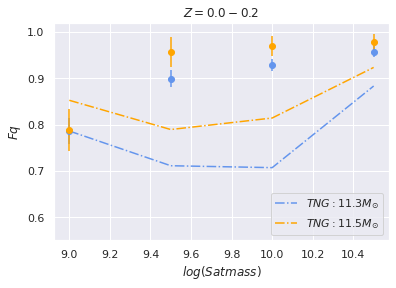

In [23]:
cen_bin = [11.3, 11.5, 11.7]
sate_bin = [9.0,9.5, 10.0, 10.5,11.0]
color0 = ['cornflowerblue','orange']   #######e','seagreen',
for i in range(2):
    for j in range(4):
       
#         if j==3:
#             continue
        data = np.load("./result_test.npy")
        plt.errorbar(sate_bin[j],data[0][i][j],data[1][i][j],color = color0[i],fmt = 'o')
# plt.errorbar(sate_bin[3],data[0][1][3],data[1][1][3],color = color0[1],fmt = 'o',label = "$Spec : %s M_{\odot}$"%cen_bin[1])
# plt.errorbar(sate_bin[3],data[0][0][3],data[1][0][3],color = color0[0],fmt = 'o',label = "$Spec : %s M_{\odot}$"%cen_bin[0])

TNG = np.load("./TNG_fq.npz")
plt.plot(sate_bin[:-1],TNG['version2'][0],color = color0[0],linestyle = '-.',label = "$TNG : 11.3 M_{\odot}$")
plt.plot(sate_bin[:-1],TNG['version2'][1],color = color0[1],linestyle = '-.',label = "$TNG : 11.5 M_{\odot}$")


plt.xlabel("$log(Sat mass)$")
plt.ylabel("$Fq$")
plt.legend(loc = "lower right")
plt.title("$Z = 0.0 - 0.2$")
plt.ylim(0.55,1.02)
# plt.plot()
# plt.savefig("/home/yunzheng/PAC/picture/PCF_colorcut/Fq_0.1.pdf",dpi = 100)

# calculation

In [9]:
num_all = np.load("./all/original_num_test.npy")
num_red = np.load("./red_galaxy/original_num_test.npy")

In [10]:
num_red/num_all

array([[0.27457247, 0.5249682 , 0.59098232, 0.71240248],
       [0.34343052, 0.52813581, 0.71635702, 0.76634197]])

In [37]:
num_all_corr = np.load("./all/corr_num.npy")
num_red_corr = np.load("./red_galaxy/corr_num.npy")

In [41]:
num_all_corr/num_all

array([[1.03147195, 1.19149187, 1.03199087, 0.9727894 ],
       [0.92138654, 1.0660988 , 1.23069389, 0.8785589 ]])

In [42]:
num_red_corr/num_red

array([[1.1753698 , 1.21256681, 1.06066883, 1.0006173 ],
       [0.87399458, 1.14021519, 1.09858799, 0.93011087]])

[0.76811558 2.40922712]
[0.01414327 0.05311881]
The length of nwp:
10
The length of rp:
11
The rp:
[0.01       0.01584893 0.02511886 0.03981072 0.06309573 0.1
 0.15848932 0.25118864 0.39810717 0.63095734 0.78877371]
The need_new:
[0.01258925 0.01995262 0.03162278 0.05011872 0.07943282 0.12589254
 0.19952623 0.31622777 0.50118723 0.79432823]
the nwp_new:
The total number:
10.850731256731207


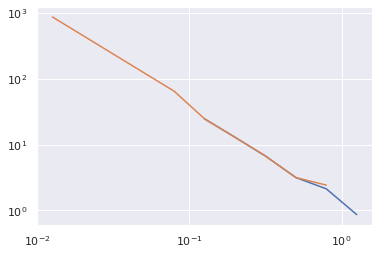

In [43]:
r = np.logspace(-2, 2, 21)
# r = r[4:-2]
r_need0 = 10**((np.log10(r0[1:])+np.log10(r0[:-1]))/2.0)

number_new = np.zeros((2,4))
for i in range(1,len(cen_bin)-1):
    for j in range(2,len(sate_bin)-2):
        nwp = np.load("/home/yunzheng/PAC/code/PAC/0_0.2/sdss_PAC/%.1f_%.1f.npy"%(cen_bin[i],sate_bin[j]),allow_pickle=True)
        plt.plot(nwp[0][1:7],nwp[1][1:7])
        plt.xscale("log")
        plt.yscale("log")

 
        def func_wp(rp,r1,gam):
            y = rp**(1-gam)*r1**gam*gamma(0.5)*gamma(0.5*(gam-1))/gamma(0.5*gam)
            return y
        

        popt,pcov = curve_fit(func_wp,nwp[0][1:7],nwp[1][1:7],sigma = nwp[2][1:7],p0=(5,2.05))
        print(popt)
        perr = np.sqrt(np.diag(pcov))
        print(perr)
        

        def part_wp1(r,rp0,r1,gam):
            y = 2*r1**gam*r**(1-gam)*(r**2 - rp0**2)**(-0.5)
            return y

        def func_wp1(rp0,rvir0,r1,gam):
            y = quad(part_wp1,rp0,rvir0,args = (rp0,popt[0],popt[1]))
            return y
        
        
       #################用函数去拟合得到100kpc以内的值#####################
        nwp_new = func_wp(r0[:5],*popt)
        index = np.searchsorted(r0,rvir[i])-1
        
#         print("The length of index in Rvir :")
#         print(index)


        nwp_new = np.hstack((nwp_new,nwp[1][1:index+1-4]))
        rp_new = np.hstack((r0[:index+1],rvir[i]))
        r_need_new = r_need0[:index+1]
        print("The length of nwp:")
        print(len(nwp_new))
        print("The length of rp:")
        print(len(rp_new))
        print("The rp:")
        print(rp_new)
        print("The need_new:")
        print(r_need_new)
        
        r_inter = (rp_new[-1] + rp_new[-2])/ 2.0
#         print("The inter r:")
#         print(r_inter)
        r_need_inter = np.array([r_need_new[-2],r_need_new[-1]])
#         print("the inter rbin:")
#         print(r_need_inter)
        nwp_inter = np.array([nwp_new[-2],nwp_new[-1]])
#         print("the nwp interbin:")
#         print(nwp_inter)

        f = interp1d(r_need_inter,nwp_inter,fill_value ='extrapolate')
        nwp_inter0 = f(r_inter)
        nwp_new = np.hstack((nwp_new[:-1],nwp_inter0))
        plt.plot(r_need_new,nwp_new)
#         print("The nwp_new:")
#         print(nwp_inter0)

    
        print("the nwp_new:")
#         print(nwp_new)
        N = np.zeros(len(rp_new)-1)
        ratio_corr_all = []
        for k in range(len(rp_new)-1):
            ratio_corr = (func_wp1(rp_new[k],rvir[i],popt[0],popt[1])[0])/func_wp(rp_new[k],*popt)
#             print(ratio_corr)
            ratio_corr_all.append(ratio_corr)
            N[k] = np.pi * (rp_new[k+1]**2-rp_new[k]**2) * nwp_new[k] * ratio_corr
#             print("The inter number")
#             print(N[k])
        print("The total number:")
        print(np.sum(N)) 
        number_new[i][j] = np.sum(N)


# np.save("./all/corr_num_test.npy",number_new)

In [44]:
ratio_corr_all

[0.9987929114264981,
 0.9976900297919198,
 0.9955791414359192,
 0.9915376720955821,
 0.9837937656090262,
 0.9689255703109817,
 0.9402309409854918,
 0.8840937337037026,
 0.7699249481253116,
 0.5010862812127975]

In [46]:
ratio_corr_all

[0.9981988521477178,
 0.9966879749127268,
 0.9939092657354544,
 0.9887972252821957,
 0.9793850229548101,
 0.9620204932698646,
 0.9298192687299897,
 0.8692891537551679,
 0.7510230761342942,
 0.4836535020952889]

[0.83417383 2.29038369]
[0.050733   0.14161686]
The length of nwp:
10
The length of rp:
11
The rp:
[0.01       0.01584893 0.02511886 0.03981072 0.06309573 0.1
 0.15848932 0.25118864 0.39810717 0.63095734 0.78877371]
The need_new:
[0.01258925 0.01995262 0.03162278 0.05011872 0.07943282 0.12589254
 0.19952623 0.31622777 0.50118723 0.79432823]
the nwp_new:
The total number:
12.646549053602707


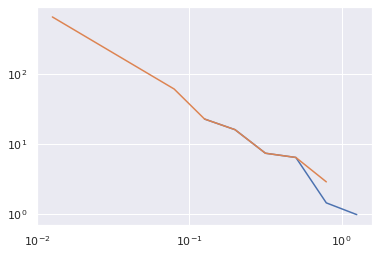

In [51]:
r = np.logspace(-2, 2, 21)
# r = r[4:-2]
r_need0 = 10**((np.log10(r0[1:])+np.log10(r0[:-1]))/2.0)

number_new = np.zeros((2,4))
for i in range(1,len(cen_bin)-1):
    for j in range(1,len(sate_bin)-3):
        nwp = np.load("/home/yunzheng/PAC/code/PAC/0_0.2/sdss_PAC/%.1f_%.1f.npy"%(cen_bin[i],sate_bin[j]),allow_pickle=True)
        plt.plot(nwp[0][1:7],nwp[1][1:7])
        plt.xscale("log")
        plt.yscale("log")

 
        def func_wp(rp,r1,gam):
            y = rp**(1-gam)*r1**gam*gamma(0.5)*gamma(0.5*(gam-1))/gamma(0.5*gam)
            return y
        

        popt,pcov = curve_fit(func_wp,nwp[0][1:8],nwp[1][1:8],sigma = nwp[2][1:8],p0=(5,2.05))
        print(popt)
        perr = np.sqrt(np.diag(pcov))
        print(perr)
        

        def part_wp1(r,rp0,r1,gam):
            y = 2*r1**gam*r**(1-gam)*(r**2 - rp0**2)**(-0.5)
            return y

        def func_wp1(rp0,rvir0,r1,gam):
            y = quad(part_wp1,rp0,rvir0,args = (rp0,popt[0],popt[1]))
            return y
        
        
       #################用函数去拟合得到100kpc以内的值#####################
        nwp_new = func_wp(r0[:5],*popt)
        index = np.searchsorted(r0,rvir[i])-1
        
#         print("The length of index in Rvir :")
#         print(index)


        nwp_new = np.hstack((nwp_new,nwp[1][1:index+1-4]))
        rp_new = np.hstack((r0[:index+1],rvir[i]))
        r_need_new = r_need0[:index+1]
        print("The length of nwp:")
        print(len(nwp_new))
        print("The length of rp:")
        print(len(rp_new))
        print("The rp:")
        print(rp_new)
        print("The need_new:")
        print(r_need_new)
        
        r_inter = (rp_new[-1] + rp_new[-2])/ 2.0
#         print("The inter r:")
#         print(r_inter)
        r_need_inter = np.array([r_need_new[-2],r_need_new[-1]])
#         print("the inter rbin:")
#         print(r_need_inter)
        nwp_inter = np.array([nwp_new[-2],nwp_new[-1]])
#         print("the nwp interbin:")
#         print(nwp_inter)

        f = interp1d(r_need_inter,nwp_inter,fill_value ='extrapolate')
        nwp_inter0 = f(r_inter)
        nwp_new = np.hstack((nwp_new[:-1],nwp_inter0))
        plt.plot(r_need_new,nwp_new)
#         print("The nwp_new:")
#         print(nwp_inter0)

    
        print("the nwp_new:")
#         print(nwp_new)
        N = np.zeros(len(rp_new)-1)
        ratio_corr_all = []
        for k in range(len(rp_new)-1):
            ratio_corr = (func_wp1(rp_new[k],rvir[i],popt[0],popt[1])[0])/func_wp(rp_new[k],*popt)
#             print(ratio_corr)
            ratio_corr_all.append(ratio_corr)
            N[k] = np.pi * (rp_new[k+1]**2-rp_new[k]**2) * nwp_new[k] * ratio_corr
#             print("The inter number")
#             print(N[k])
        print("The total number:")
        print(np.sum(N)) 
        number_new[i][j] = np.sum(N)


# np.save("./all/corr_num_test.npy",number_new)

This is the central bin:
11.6
This is the sat bin:
10.0
[0.66645046 2.30003697]
[0.01137267 0.05251205]
The length of nwp:
10
The length of rp:
11
The rp:
[0.01       0.01584893 0.02511886 0.03981072 0.06309573 0.1
 0.15848932 0.25118864 0.39810717 0.63095734 0.78877371]
The need_new:
[0.01258925 0.01995262 0.03162278 0.05011872 0.07943282 0.12589254
 0.19952623 0.31622777 0.50118723 0.79432823]
the nwp_new:
The total number:
6.938623674432429


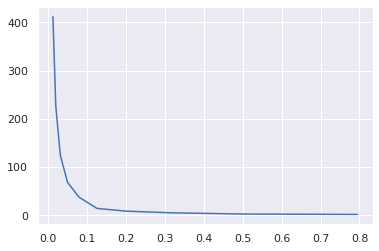

In [47]:
r = np.logspace(-2, 2, 21)
# r = r[4:-2]
r_need0 = 10**((np.log10(r0[1:])+np.log10(r0[:-1]))/2.0)

number_new = np.zeros((2,4))
for i in range(1,len(cen_bin)-1):
    print("This is the central bin:")
    print(cen_bin[i])
    for j in range(2,len(sate_bin)-2):
        print("This is the sat bin:")
        print(sate_bin[j])
        nwp = np.load("/home/yunzheng/PAC/code/PAC/0_0.2/color_cut_red/%.1f_%.1f.npy"%(cen_bin[i],sate_bin[j]),allow_pickle=True)
#         plt.plot(nwp[0][1:7],nwp[1][1:7])
#         plt.xscale("log")
#         plt.yscale("log")

 
        def func_wp(rp,r1,gam):
            y = rp**(1-gam)*r1**gam*gamma(0.5)*gamma(0.5*(gam-1))/gamma(0.5*gam)
            return y
        

        popt,pcov = curve_fit(func_wp,nwp[0][1:7],nwp[1][1:7],sigma = nwp[2][1:7],p0=(5,2.05))
        print(popt)
        perr = np.sqrt(np.diag(pcov))
        print(perr)
        

        def part_wp1(r,rp0,r1,gam):
            y = 2*r1**gam*r**(1-gam)*(r**2 - rp0**2)**(-0.5)
            return y

        def func_wp1(rp0,rvir0,r1,gam):
            y = quad(part_wp1,rp0,rvir0,args = (rp0,popt[0],popt[1]))
            return y
        
        
       #################用函数去拟合得到100kpc以内的值#####################
        nwp_new = func_wp(r0[:5],*popt)
        index = np.searchsorted(r0,rvir[i])-1
        
#         print("The length of index in Rvir :")
#         print(index)


        nwp_new = np.hstack((nwp_new,nwp[1][1:index+1-4]))
        rp_new = np.hstack((r0[:index+1],rvir[i]))
        r_need_new = r_need0[:index+1]
        print("The length of nwp:")
        print(len(nwp_new))
        print("The length of rp:")
        print(len(rp_new))
        print("The rp:")
        print(rp_new)
        print("The need_new:")
        print(r_need_new)
        
        r_inter = (rp_new[-1] + rp_new[-2])/ 2.0
#         print("The inter r:")
#         print(r_inter)
        r_need_inter = np.array([r_need_new[-2],r_need_new[-1]])
#         print("the inter rbin:")
#         print(r_need_inter)
        nwp_inter = np.array([nwp_new[-2],nwp_new[-1]])
#         print("the nwp interbin:")
#         print(nwp_inter)

        f = interp1d(r_need_inter,nwp_inter,fill_value ='extrapolate')
        nwp_inter0 = f(r_inter)
        nwp_new = np.hstack((nwp_new[:-1],nwp_inter0))
        plt.plot(r_need_new,nwp_new)
#         print("The nwp_new:")
#         print(nwp_inter0)

    
        print("the nwp_new:")
#         print(nwp_new)
        N = np.zeros(len(rp_new)-1)
        ratio_corr_red = []
        for k in range(len(rp_new)-1):
            ratio_corr = (func_wp1(rp_new[k],rvir[i],popt[0],popt[1])[0])/func_wp(rp_new[k],*popt)
#             print(ratio_corr)
            ratio_corr_red.append(ratio_corr)
            N[k] = np.pi * (rp_new[k+1]**2-rp_new[k]**2) * nwp_new[k] * ratio_corr
#             print("The inter number")
#             print(N[k])
        print("The total number:")
        print(np.sum(N)) 
        number_new[i][j] = np.sum(N)


# np.save("./all/corr_num_test.npy",number_new)

In [48]:
ratio_corr_red

[0.9980004689842253,
 0.9963612155386505,
 0.9933775914467079,
 0.9879453474247573,
 0.9780470622754218,
 0.9599747057947435,
 0.9268077605002962,
 0.8651083238755666,
 0.7458107299136647,
 0.47895839221883496]

In [50]:
ratio_corr_red

[0.9984430231662359,
 0.9970951253906583,
 0.9945799304077038,
 0.9898850582349898,
 0.9811146050099228,
 0.9646975207793494,
 0.9338080822665835,
 0.874893835765274,
 0.7580943594801116,
 0.4900984676376276]

This is the central bin:
11.6
This is the sat bin:
9.5
[0.65755207 2.35411966]
[0.01212654 0.05420891]
The length of nwp:
10
The length of rp:
11
The rp:
[0.01       0.01584893 0.02511886 0.03981072 0.06309573 0.1
 0.15848932 0.25118864 0.39810717 0.63095734 0.78877371]
The need_new:
[0.01258925 0.01995262 0.03162278 0.05011872 0.07943282 0.12589254
 0.19952623 0.31622777 0.50118723 0.79432823]
the nwp_new:
The total number:
7.29858783916827


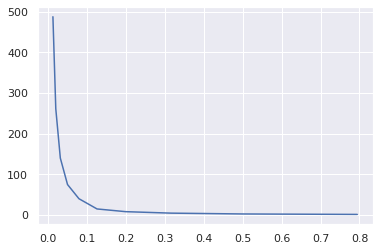

In [49]:
r = np.logspace(-2, 2, 21)
# r = r[4:-2]
r_need0 = 10**((np.log10(r0[1:])+np.log10(r0[:-1]))/2.0)

number_new = np.zeros((2,4))
for i in range(1,len(cen_bin)-1):
    print("This is the central bin:")
    print(cen_bin[i])
    for j in range(2,len(sate_bin)-1):
        print("This is the sat bin:")
        print(sate_bin[j])
        nwp = np.load("/home/yunzheng/PAC/code/PAC/0_0.2/color_cut_red/%.1f_%.1f.npy"%(cen_bin[i],sate_bin[j]),allow_pickle=True)
#         plt.plot(nwp[0][1:7],nwp[1][1:7])
#         plt.xscale("log")
#         plt.yscale("log")

 
        def func_wp(rp,r1,gam):
            y = rp**(1-gam)*r1**gam*gamma(0.5)*gamma(0.5*(gam-1))/gamma(0.5*gam)
            return y
        

        popt,pcov = curve_fit(func_wp,nwp[0][1:7],nwp[1][1:7],sigma = nwp[2][1:7],p0=(5,2.05))
        print(popt)
        perr = np.sqrt(np.diag(pcov))
        print(perr)
        

        def part_wp1(r,rp0,r1,gam):
            y = 2*r1**gam*r**(1-gam)*(r**2 - rp0**2)**(-0.5)
            return y

        def func_wp1(rp0,rvir0,r1,gam):
            y = quad(part_wp1,rp0,rvir0,args = (rp0,popt[0],popt[1]))
            return y
        
        
       #################用函数去拟合得到100kpc以内的值#####################
        nwp_new = func_wp(r0[:5],*popt)
        index = np.searchsorted(r0,rvir[i])-1
        
#         print("The length of index in Rvir :")
#         print(index)


        nwp_new = np.hstack((nwp_new,nwp[1][1:index+1-4]))
        rp_new = np.hstack((r0[:index+1],rvir[i]))
        r_need_new = r_need0[:index+1]
        print("The length of nwp:")
        print(len(nwp_new))
        print("The length of rp:")
        print(len(rp_new))
        print("The rp:")
        print(rp_new)
        print("The need_new:")
        print(r_need_new)
        
        r_inter = (rp_new[-1] + rp_new[-2])/ 2.0
#         print("The inter r:")
#         print(r_inter)
        r_need_inter = np.array([r_need_new[-2],r_need_new[-1]])
#         print("the inter rbin:")
#         print(r_need_inter)
        nwp_inter = np.array([nwp_new[-2],nwp_new[-1]])
#         print("the nwp interbin:")
#         print(nwp_inter)

        f = interp1d(r_need_inter,nwp_inter,fill_value ='extrapolate')
        nwp_inter0 = f(r_inter)
        nwp_new = np.hstack((nwp_new[:-1],nwp_inter0))
        plt.plot(r_need_new,nwp_new)
#         print("The nwp_new:")
#         print(nwp_inter0)

    
        print("the nwp_new:")
#         print(nwp_new)
        N = np.zeros(len(rp_new)-1)
        ratio_corr_red = []
        for k in range(len(rp_new)-1):
            ratio_corr = (func_wp1(rp_new[k],rvir[i],popt[0],popt[1])[0])/func_wp(rp_new[k],*popt)
#             print(ratio_corr)
            ratio_corr_red.append(ratio_corr)
            N[k] = np.pi * (rp_new[k+1]**2-rp_new[k]**2) * nwp_new[k] * ratio_corr
#             print("The inter number")
#             print(N[k])
        print("The total number:")
        print(np.sum(N)) 
        number_new[i][j] = np.sum(N)


# np.save("./all/corr_num_test.npy",number_new)

This is the central bin:
11.4
This is the sat bin:
10.0
[0.65016319 2.19342756]
[0.01644131 0.06789724]
The length of nwp:
10
The length of rp:
11
The rp:
[0.01       0.01584893 0.02511886 0.03981072 0.06309573 0.1
 0.15848932 0.25118864 0.39810717 0.63095734 0.6434969 ]
The need_new:
[0.01258925 0.01995262 0.03162278 0.05011872 0.07943282 0.12589254
 0.19952623 0.31622777 0.50118723 0.79432823]
the nwp_new:
0.9958207327362792
0.9927587207523086
0.9874519774032894
0.9782505578957975
0.9622770576357846
0.9344631597882461
0.8856516425590822
0.7981624475109969
0.6308174652303883
0.14183620676696848
The total number:
5.298968612503194


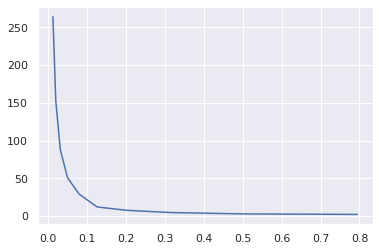

In [36]:
r = np.logspace(-2, 2, 21)
# r = r[4:-2]
r_need0 = 10**((np.log10(r0[1:])+np.log10(r0[:-1]))/2.0)

number_new = np.zeros((2,4))
for i in range(len(cen_bin)-2):
    print("This is the central bin:")
    print(cen_bin[i])
    for j in range(2,len(sate_bin)-2):
        print("This is the sat bin:")
        print(sate_bin[j])
        nwp = np.load("/home/yunzheng/PAC/code/PAC/0_0.2/sdss_PAC/%.1f_%.1f.npy"%(cen_bin[i],sate_bin[j]),allow_pickle=True)
#         plt.plot(nwp[0][1:7],nwp[1][1:7])
#         plt.xscale("log")
#         plt.yscale("log")

 
        def func_wp(rp,r1,gam):
            y = rp**(1-gam)*r1**gam*gamma(0.5)*gamma(0.5*(gam-1))/gamma(0.5*gam)
            return y
        

        popt,pcov = curve_fit(func_wp,nwp[0][1:7],nwp[1][1:7],sigma = nwp[2][1:7],p0=(5,2.05))
        print(popt)
        perr = np.sqrt(np.diag(pcov))
        print(perr)
        

        def part_wp1(r,rp0,r1,gam):
            y = 2*r1**gam*r**(1-gam)*(r**2 - rp0**2)**(-0.5)
            return y

        def func_wp1(rp0,rvir0,r1,gam):
            y = quad(part_wp1,rp0,rvir0,args = (rp0,popt[0],popt[1]))
            return y
        
        
       #################用函数去拟合得到100kpc以内的值#####################
        nwp_new = func_wp(r0[:5],*popt)
        index = np.searchsorted(r0,rvir[i])-1
        
#         print("The length of index in Rvir :")
#         print(index)


        nwp_new = np.hstack((nwp_new,nwp[1][1:index+1-4]))
        rp_new = np.hstack((r0[:index+1],rvir[i]))
        r_need_new = r_need0[:index+1]
        print("The length of nwp:")
        print(len(nwp_new))
        print("The length of rp:")
        print(len(rp_new))
        print("The rp:")
        print(rp_new)
        print("The need_new:")
        print(r_need_new)
        
        r_inter = (rp_new[-1] + rp_new[-2])/ 2.0
#         print("The inter r:")
#         print(r_inter)
        r_need_inter = np.array([r_need_new[-2],r_need_new[-1]])
#         print("the inter rbin:")
#         print(r_need_inter)
        nwp_inter = np.array([nwp_new[-2],nwp_new[-1]])
#         print("the nwp interbin:")
#         print(nwp_inter)

        f = interp1d(r_need_inter,nwp_inter,fill_value ='extrapolate')
        nwp_inter0 = f(r_inter)
        nwp_new = np.hstack((nwp_new[:-1],nwp_inter0))
        plt.plot(r_need_new,nwp_new)
#         print("The nwp_new:")
#         print(nwp_inter0)

    
        print("the nwp_new:")
#         print(nwp_new)
        N = np.zeros(len(rp_new)-1)
        for k in range(len(rp_new)-1):
            ratio_corr = (func_wp1(rp_new[k],rvir[i],popt[0],popt[1])[0])/func_wp(rp_new[k],*popt)
            print(ratio_corr)
            N[k] = np.pi * (rp_new[k+1]**2-rp_new[k]**2) * nwp_new[k] * ratio_corr
#             print("The inter number")
#             print(N[k])
        print("The total number:")
        print(np.sum(N)) 
        number_new[i][j] = np.sum(N)


# np.save("./all/corr_num_test.npy",number_new)

In [35]:
r = np.logspace(-2, 2, 21)
# r = r[4:-2]
r_need0 = 10**((np.log10(r0[1:])+np.log10(r0[:-1]))/2.0)

number_new = np.zeros((2,4))
for i in range(len(cen_bin)-2):
    print("This is the central bin:")
    print(cen_bin[i])
    for j in range(2,len(sate_bin)-2):
        print("This is the sat bin:")
        print(sate_bin[j])
        nwp = np.load("/home/yunzheng/PAC/code/PAC/0_0.2/color_cut_red/%.1f_%.1f.npy"%(cen_bin[i],sate_bin[j]),allow_pickle=True)
#         plt.plot(nwp[0][1:7],nwp[1][1:7],'.')
#         plt.xscale("log")
#         plt.yscale("log")

 
        def func_wp(rp,r1,gam):
            y = rp**(1-gam)*r1**gam*gamma(0.5)*gamma(0.5*(gam-1))/gamma(0.5*gam)
            return y
        

        popt,pcov = curve_fit(func_wp,nwp[0][1:7],nwp[1][1:7],sigma = nwp[2][1:7],p0=(5,2.05))
        print(popt)
        perr = np.sqrt(np.diag(pcov))
        print(perr)
        

        def part_wp1(r,rp0,r1,gam):
            y = 2*r1**gam*r**(1-gam)*(r**2 - rp0**2)**(-0.5)
            return y

        def func_wp1(rp0,rvir0,r1,gam):
            y = quad(part_wp1,rp0,rvir0,args = (rp0,popt[0],popt[1]))
            return y
        
        
       #################用函数去拟合得到100kpc以内的值#####################
        nwp_new = func_wp(r0[:5],*popt)
        index = np.searchsorted(r0,rvir[i])-1
        
#         print("The length of index in Rvir :")
#         print(index)


        nwp_new = np.hstack((nwp_new,nwp[1][1:index+1-4]))
        rp_new = np.hstack((r0[:index+1],rvir[i]))
        r_need_new = r_need0[:index+1]
        print("The length of nwp:")
        print(len(nwp_new))
        print("The length of rp:")
        print(len(rp_new))
        print("The rp:")
        print(rp_new)
        print("The need_new:")
        print(r_need_new)
        
        r_inter = (rp_new[-1] + rp_new[-2])/ 2.0
#         print("The inter r:")
#         print(r_inter)
        r_need_inter = np.array([r_need_new[-2],r_need_new[-1]])
#         print("the inter rbin:")
#         print(r_need_inter)
        nwp_inter = np.array([nwp_new[-2],nwp_new[-1]])
#         print("the nwp interbin:")
#         print(nwp_inter)

        f = interp1d(r_need_inter,nwp_inter,fill_value ='extrapolate')
        nwp_inter0 = f(r_inter)
        nwp_new = np.hstack((nwp_new[:-1],nwp_inter0))
#         plt.plot(r_need_new,nwp_new)
#         print("The nwp_new:")
#         print(nwp_inter0)

    
        print("the nwp_new:")
        print(nwp_new)
        N = np.zeros(len(rp_new)-1)
        for k in range(len(rp_new)-1):
            ratio_corr = (func_wp1(rp_new[k],rvir[i],popt[0],popt[1])[0])/func_wp(rp_new[k],*popt)
            print(ratio_corr)
            N[k] = np.pi * (rp_new[k+1]**2-rp_new[k]**2) * nwp_new[k] * ratio_corr
#             print("The inter number")
#             print(N[k])
        print("The total number:")
        print(np.sum(N)) 
        number_new[i][j] = np.sum(N)


# np.save("./all/corr_num_test.npy",number_new)

This is the central bin:
11.4
This is the sat bin:
10.0
[0.51665698 2.21357489]
[0.01080725 0.06377193]
The length of nwp:
10
The length of rp:
11
The rp:
[0.01       0.01584893 0.02511886 0.03981072 0.06309573 0.1
 0.15848932 0.25118864 0.39810717 0.63095734 0.6434969 ]
The need_new:
[0.01258925 0.01995262 0.03162278 0.05011872 0.07943282 0.12589254
 0.19952623 0.31622777 0.50118723 0.79432823]
the nwp_new:
[170.69320802  97.6115621   55.81954412  31.92061922  18.25392786
   7.32593561   4.78796266   2.79714879   1.61302057   1.25069204]
0.9961782523776362
0.9933164541668318
0.9883104666480773
0.9795496174459878
0.964199153198909
0.9372208751575081
0.8894340685748833
0.8029810307139292
0.6360630694328556
0.1434166138586776
The total number:
3.218620571469886


In [34]:
ratio_corr

0.1434166138586776